In [2]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [60]:
df = pd.read_csv('sentiment-sentence-level.csv')

In [61]:
df.head()

,Unnamed: 0,review_index,date,review,rating,status,length,label,language,scores,compound,sentiment
0,0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,en,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...",0.8555,pos
1,1,0,2021-03-11,Thanks,5,completer,6,pos,en,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4404,pos
2,2,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,63,pos,en,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.8519,pos
3,3,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,48,pos,en,"{'neg': 0.0, 'neu': 0.44, 'pos': 0.56, 'compou...",0.6249,pos
4,4,1,2021-03-11,There are some cute moments that make you smil...,5,completer,50,pos,en,"{'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'comp...",0.8176,pos


In [62]:
df.drop(['Unnamed: 0', 'date', 'language', 'scores'], axis = 1, inplace = True)

In [63]:
df

,review_index,review,rating,status,length,label,compound,sentiment
0,0,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,0.8555,pos
1,0,Thanks,5,completer,6,pos,0.4404,pos
2,1,Super easy and totally for the beginners like ...,5,completer,63,pos,0.8519,pos
3,1,Professor's explanations are clear like crystal.,5,completer,48,pos,0.6249,pos
4,1,There are some cute moments that make you smil...,5,completer,50,pos,0.8176,pos
...,...,...,...,...,...,...,...,...
14469,9687,My friend recommanded the lecture.,5,dropout,34,pos,0.4939,pos
14470,9687,It really deserves five star rate!,5,dropout,34,pos,0.0000,neu
14471,9688,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
14472,9689,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [64]:
# Check for null values

len(df[df['review'].isna()==True])

526

In [65]:
# Drop null values

df.dropna(inplace = True)

In [66]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [ ]:
# Reset the index

df = df.reset_index(drop = True)

In [67]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

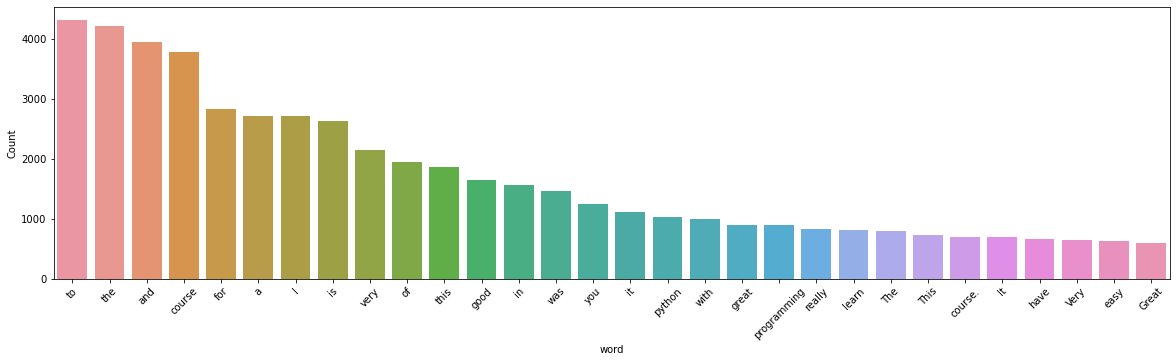

In [68]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [69]:
# Covert to lowercase

df['review'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['review'].head()

0    nice course for beginners where we can enjoy a...
1                                               thanks
2    super easy and totally for the beginners like ...
3     professor's explanations are clear like crystal.
4    there are some cute moments that make you smil...
Name: review, dtype: object

In [70]:
# Remove punctuations

df['review'] = df['review'].str.replace('[^\w\s]','')
df['review'].head()

0    nice course for beginners where we can enjoy a...
1                                               thanks
2    super easy and totally for the beginners like ...
3       professors explanations are clear like crystal
4     there are some cute moments that make you smile 
Name: review, dtype: object

In [71]:
# Remove stopwords

stop = stopwords.words('english')

df['review'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['review'].head()

0    nice course beginners enjoy learn well dr chuc...
1                                               thanks
2       super easy totally beginners like course title
3           professors explanations clear like crystal
4                              cute moments make smile
Name: review, dtype: object

In [72]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

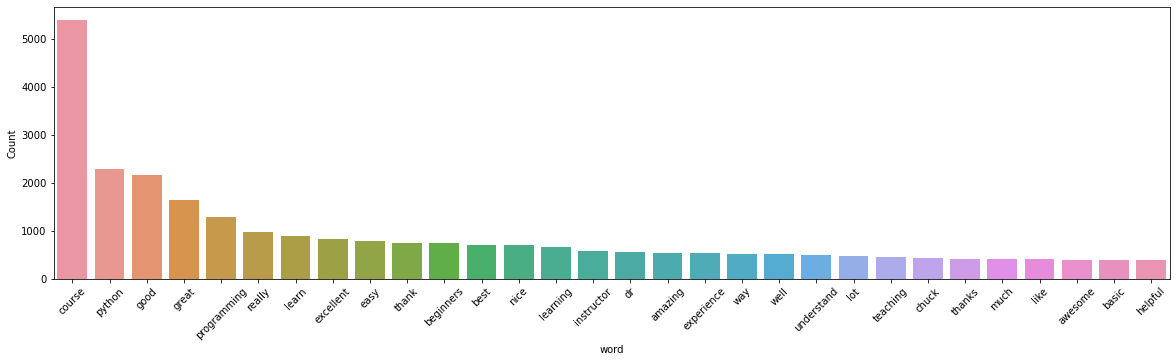

In [73]:
# Look at the most frequent words again 

freq_words(df['review'])

In [90]:
# Remove additional noice with lemmatization using the spacy library

nlp = spacy.load('en', disable=['parser', 'ner'])

# Define function for lemmatization

def lemmatization(texts, tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output


In [91]:
# Tokenize reviews

tokenized_reviews = pd.Series(df['review']).apply(lambda x: x.split())
print(tokenized_reviews[0])

['nice', 'course', 'beginners', 'enjoy', 'learn', 'well', 'dr', 'chuck', 'made', 'huge', 'impact', 'basic', 'control', 'flow', 'python']


In [92]:
# Apply lemmatization function

lemmatized_reviews = lemmatization(tokenized_reviews)
print(lemmatized_reviews[0]) # print lemmatized review

['nice', 'course', 'beginner', 'enjoy', 'learn', 'well', 'make', 'huge', 'impact', 'basic', 'control', 'flow']


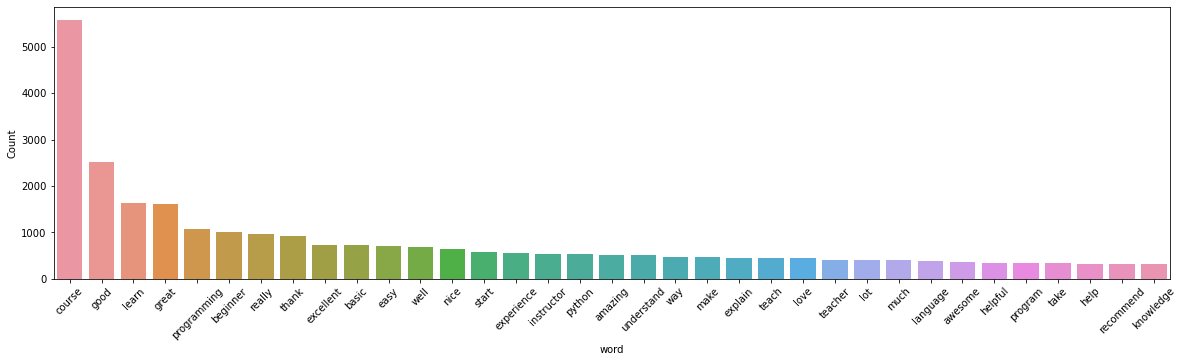

In [93]:
joined_reviews = []
for i in range(len(lemmatized_reviews)):
    joined_reviews.append(' '.join(lemmatized_reviews[i]))

df['lemmatized_reviews'] = joined_reviews

freq_words(df['lemmatized_reviews'], 35)

## LDA Topic Modeling

In [94]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(lemmatized_reviews)

In [95]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [96]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in lemmatized_reviews]


In [113]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 7, random_state = 100,
                chunksize = 1000, passes = 50)

In [114]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))

Topic: 0
Word: 0.157*"course" + 0.118*"amazing" + 0.089*"awesome" + 0.075*"program" + 0.070*"useful" + 0.048*"thing" + 0.045*"complete" + 0.045*"learn" + 0.039*"get" + 0.035*"be"

Topic: 1
Word: 0.115*"easy" + 0.106*"nice" + 0.094*"course" + 0.076*"make" + 0.063*"understand" + 0.045*"learn" + 0.040*"fun" + 0.038*"class" + 0.033*"first" + 0.030*"time"

Topic: 2
Word: 0.290*"course" + 0.187*"great" + 0.099*"beginner" + 0.080*"learn" + 0.053*"start" + 0.048*"really" + 0.044*"helpful" + 0.040*"love" + 0.034*"want" + 0.030*"lot"

Topic: 3
Word: 0.577*"good" + 0.091*"experience" + 0.067*"teaching" + 0.050*"learning" + 0.029*"explanation" + 0.024*"teacher" + 0.024*"exercise" + 0.023*"platform" + 0.017*"work" + 0.017*"week"

Topic: 4
Word: 0.113*"thank" + 0.108*"programming" + 0.092*"course" + 0.091*"basic" + 0.065*"python" + 0.058*"learn" + 0.048*"much" + 0.046*"language" + 0.040*"knowledge" + 0.039*"help"

Topic: 5
Word: 0.087*"really" + 0.084*"instructor" + 0.067*"explain" + 0.041*"teacher"

In [115]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.133245 -0.148758       1        1  18.071022
2     -0.174441  0.107494       2        1  17.379595
5      0.255421  0.294783       3        1  15.861556
1     -0.061344 -0.178193       4        1  14.176474
6     -0.114313  0.152867       5        1  13.160065
0     -0.171020 -0.037222       6        1  10.889593
3      0.398941 -0.190970       7        1  10.461696, topic_info=             Term         Freq        Total Category  logprob  loglift
26           good  2666.000000  2666.000000  Default  30.0000  30.0000
32          great  1437.000000  1437.000000  Default  29.0000  29.0000
2          course  5509.000000  5509.000000  Default  28.0000  28.0000
22          thank   898.000000   898.000000  Default  27.0000  27.0000
49      excellent   756.000000   756.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
122       content     0.143746   202.690307   Topic7 -10.3777  -4.9939
91          skill     0.143737   125.671026   Topic7 -10.3777  -4.5160
18   introduction     0.143721   163.730904   Topic7 -10.3778  -4.7807
117        person     0.143721    72.082994   Topic7 -10.3779  -3.9603
9           clear     0.143710   189.522752   Topic7 -10.3779  -4.9270

[280 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
157       1  0.238483        able
157       3  0.749517        able
151       3  0.983775  absolutely
128       1  0.752471     already
128       4  0.232582     already
...     ...       ...         ...
19        2  0.161431       world
19        4  0.819573       world
101       3  0.994824       would
136       3  0.721750       write
136       6  0.268079       write

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 2, 7, 1, 4])

In [134]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = lemmatized_reviews, dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.635312233476272

Coherence Score:  0.3448362815928226


## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [130]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [131]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = lemmatized_reviews, start = 2, limit = 10, step = 1)

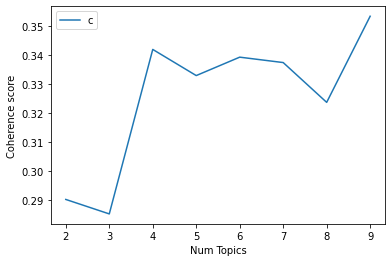

In [132]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [133]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2903
Num Topics = 3  has Coherence Value of 0.2853
Num Topics = 4  has Coherence Value of 0.3421
Num Topics = 5  has Coherence Value of 0.3331
Num Topics = 6  has Coherence Value of 0.3394
Num Topics = 7  has Coherence Value of 0.3375
Num Topics = 8  has Coherence Value of 0.3238
Num Topics = 9  has Coherence Value of 0.3535


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [128]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 4, id2word = dictionary)

In [129]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = lemmatized_reviews, dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('programming', 0.14439365420812048),
   ('beginner', 0.09115353589674643),
   ('nice', 0.0860446356547459),
   ('great', 0.07555794568432374),
   ('experience', 0.0740790535090078),
   ('good', 0.07085237967195483),
   ('basic', 0.056601236891637534),
   ('language', 0.05108900242000538),
   ('awesome', 0.0501478892175316),
   ('helpful', 0.04732454961011025)]),
 (1,
  [('learn', 0.2228000547420282),
   ('good', 0.16326809908307102),
   ('great', 0.09908307102778158),
   ('start', 0.07923908580812919),
   ('lot', 0.056794854249349935),
   ('beginner', 0.045846448610921034),
   ('program', 0.04543588339947995),
   ('basic', 0.03941426029834405),
   ('enjoy', 0.03517175311345285),
   ('assignment', 0.030792390858081293)]),
 (2,
  [('good', 0.11121843521457155),
   ('amazing', 0.0714778529046502),
   ('python', 0.06361252932247827),
   ('love', 0.05988684973092314),
   ('great', 0.04332827376845591),
   ('knowledge', 0.043052297502414794),
   ('teaching', 0.04056851110804471),
  